# Data preparation

In [2]:
# Based on the codes in the Eduardo's code as well as the code in the Spotipy documentation https://spotipy.readthedocs.io/en/2.22.1/

# import dependencies
import spotipy as sp
from spotipy.oauth2 import SpotifyClientCredentials
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Authorisation
from config import CLIENT_ID
from config import CLIENT_SECRET

# Initialize the Spotify client with client credentials flow
client_credentials_manager = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
sp = sp.Spotify(client_credentials_manager=client_credentials_manager)



In [3]:
# Changed a couple of the links, so we have consistent data. 
# We had top TRACKS playlist for a couple of years (len = 50) but top HITS for the other years (len = 100), 
# so I've made it consistent
Years = {"2017": "https://open.spotify.com/playlist/37i9dQZF1DWTE7dVUebpUW",
        "2018": "https://open.spotify.com/playlist/37i9dQZF1DXe2bobNYDtW8",
        "2019": "https://open.spotify.com/playlist/37i9dQZF1DWVRSukIED0e9",
        "2020": "https://open.spotify.com/playlist/2fmTTbBkXi8pewbUvG3CeZ",
        "2021": "https://open.spotify.com/playlist/5GhQiRkGuqzpWZSE7OU4Se",
        "2022": "https://open.spotify.com/playlist/56r5qRUv3jSxADdmBkhcz7"}

# set empty lists to add data to
track_features = []
track_id = []
track_name = []
track_popularity = []
artist_name = []
artist_id = []
artist_genre = []

# loop through years to request data we need for each year
for year in Years:
    playlist_URI = Years[year]
    
    # apend gave me a list of lists, so using extend instead    
    # get tracks for this year
    track_id_this_year = [x["track"]["id"] for x in sp.playlist_tracks(playlist_URI)["items"]]
   
    # get track features
    track_features.extend(sp.audio_features(track_id_this_year))    
    
    #get the rest of tracks info
    track_id.extend(track_id_this_year)
    track_name.extend ([x["track"]["name"] for x in sp.playlist_tracks(playlist_URI)["items"]])
    track_popularity.extend ([x["track"]["popularity"] for x in sp.playlist_tracks(playlist_URI)["items"]])
    
    # get artist info
    artist_name.extend([x["track"]["artists"][0]["name"] for x in sp.playlist_tracks(playlist_URI)["items"]])
    artist_id.extend([x["track"]["artists"][0]["id"] for x in sp.playlist_tracks(playlist_URI)["items"]])
    
    # get artist uri so we can get genre
    artist_uri = [x["track"]["artists"][0]["uri"] for x in sp.playlist_tracks(playlist_URI)["items"]]
    artist_genre.extend([sp.artist(uri)["genres"] for uri in artist_uri])
    

In [4]:
# join all the information in a dataframe

# first the track info
years = ['2017', '2018', '2019', '2020', '2021', '2022']
year_index = np.repeat(years,100)

track_info = pd.DataFrame({"Year": year_index,
                           "id" : track_id,
                           "artist id" : artist_id,
                           "track name" : track_name,
                           "artist name" : artist_name,
                           "artist genre": artist_genre,
                           "track popularity" : track_popularity})

# then the track features
track_features_df = pd.DataFrame(track_features)

# and now merge the two
complete_df = pd.merge(track_info, track_features_df, on = "id", how = "inner")

# the merged df has 44 duplicates, so getting rid of them here. We end up with a df with len = 600 (100 songs for each year)
complete_df = complete_df.drop_duplicates(["id", "Year"])

# save output
#complete_df.to_csv('output_data/spotipy_data.csv')


## Each Top 100 seemed to be in order of most streamed track. First I looked at the first 10 artists to appear in each list and the name of the track in that position.

In [5]:
# Group the data by 'Year' to prepare for extraction
grouped_by_year = complete_df.groupby('Year')

# Display the first 10 artists and songs for each year
for year, group in grouped_by_year:
    top_10_year = group.head(10)
    print(f"\nTop 10 in {year}:\n")
    print(top_10_year[['artist name', 'track name']])


Top 10 in 2017:

         artist name                               track name
0         Ed Sheeran                             Shape of You
1    Imagine Dragons                                 Believer
2         Luis Fonsi                                Despacito
3  Machine Gun Kelly         Bad Things (with Camila Cabello)
4       Clean Bandit  Rockabye (feat. Sean Paul & Anne-Marie)
5     Camila Cabello                Havana (feat. Young Thug)
6    Imagine Dragons                                  Thunder
7           Maroon 5  Don't Wanna Know (feat. Kendrick Lamar)
8   The Chainsmokers                 Something Just Like This
9         Ed Sheeran                                  Perfect

Top 10 in 2018:

          artist name                                         track name
31     Kendrick Lamar                                LOVE. FEAT. ZACARI.
53             G-Eazy                              Him & I (with Halsey)
73   Hailee Steinfeld  Let Me Go (with Alesso, Florida Georgia 

Then I was curious to see what the average song count per artist was for each year.

In [7]:
# Group data by Year and artist name then count unique songs and calculate the average
songs_per_artist = complete_df.groupby(['Year',
                                        'artist name'])['id'].nunique().reset_index(name='num_songs')

# Calculate average songs per artist for each year
avg_songs_per_artist = songs_per_artist.groupby('Year'
                                                   )['num_songs'
                                                    ].mean().reset_index(name='avg_songs_per_artist')

# Convert into a DataFrame for readability
avg_songs_per_artist_df = pd.DataFrame(avg_songs_per_artist)
avg_songs_per_artist_df = avg_songs_per_artist_df.rename(columns={'avg_songs_per_artist'
                                                                  : 'Average Song Per Artist'})

avg_songs_per_artist_df

,Year,Average Song Per Artist
0,2017,1.315789
1,2018,1.282051
2,2019,1.388889
3,2020,1.449275
4,2021,1.562500
5,2022,1.470588


## After finding out the averages I decided to look at which artists had multiple songs appearing in each top 100 list only selecting the first five in decenting order.

In [8]:
# Get top 5 most active artists per year:
# Group data by Year and artist name then count occurrences and sort the values
artist_activity = complete_df.groupby(['Year', 'artist name'
                                      ]).size().reset_index(name='song_count'
                                                           ).sort_values(by=['Year', 'song_count'
                                                                            ], ascending=[True, False])

# Get the top 5 active artists for each year
five_successful_artists_by_year = artist_activity.groupby('Year').head(5)

# Convert into a DataFrame for readability
yearly_five_artist_df = pd.DataFrame(five_successful_artists_by_year)
yearly_five_artist_df = yearly_five_artist_df.rename(columns={'song_count': '# Songs',
                                                    'artist name': 'Artist Name'})

yearly_five_artist_df

,Year,Artist Name,# Songs
20,2017,Ed Sheeran,5
34,2017,Kendrick Lamar,4
27,2017,Imagine Dragons,3
5,2017,Avicii,2
9,2017,Bruno Mars,2
96,2018,Drake,5
124,2018,Marshmello,4
87,2018,Cardi B,3
125,2018,Migos,3
132,2018,Post Malone,3


## This table was not very easy to interprit so I felt a bar graph would privide the best visualisation.

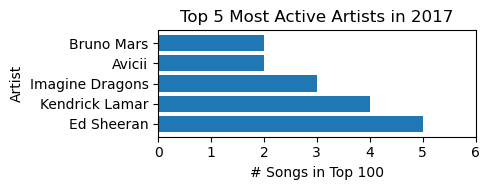

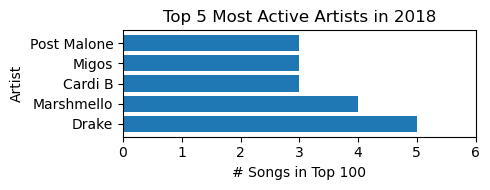

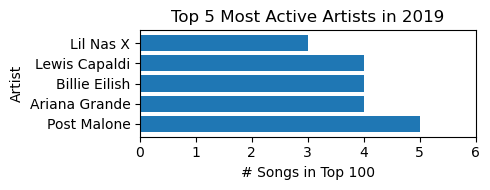

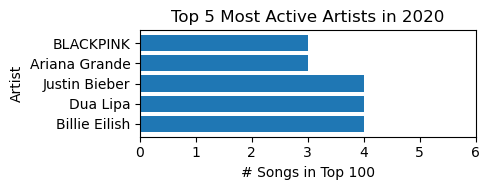

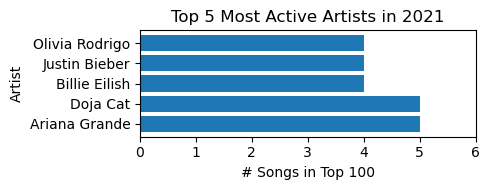

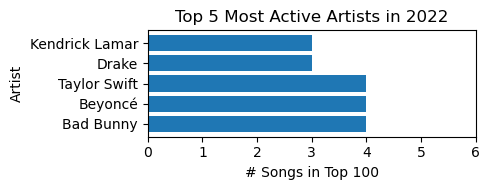

In [15]:
# Group the data by Year and artist name to prepare for plotting
grouped_data = five_successful_artists_by_year.groupby('Year')

# Create separate plots for each year
for name, group in grouped_data:
    plt.figure(figsize=(5, 2))
    plt.barh(group['artist name'], group['song_count'])
    plt.xlabel('# Songs in Top 100')
    plt.ylabel('Artist')
    plt.title(f'Top 5 Most Active Artists in {name}')
    plt.xlim(0, 6)
    plt.tight_layout()
    plt.savefig(f"../output_data/top_active_artists_song_count_{name}.png", bbox_inches='tight')
    plt.show()

## With this information I wanted to find out if track duration may have coontributed to these artists having multiple top 100 tracks so I worked out each artists average track duration per year.

In [17]:
# Extract track durations
track_durations = [track['duration_ms'] for track in track_features]
# Convert track durations from ms to mins
track_durations_minutes = [duration / 60000 for duration in track_durations]

# Add track durations to the existing DataFrame
complete_df['track_duration_mins'] = track_durations_minutes

# Group data by Year and artist name to calculate the average track duration for top 5 artists
grouped_by_artist = complete_df.groupby(['Year', 'artist name'])

# Get the top 5 artists for each year based on song count
for year, group in five_successful_artists_by_year.groupby('Year'):
    print(f"\nYear: {year}")
    for index, row in group.iterrows():
        artist_name = row['artist name']
        # Filter data for the specific artist in the given year
        artist_data = grouped_by_artist.get_group((year, artist_name))
        # Calculate average track duration for the artist
        average_duration = artist_data['track_duration_mins'].mean()
        print(f"Artist Name (AVG Track Duration): {artist_name} ({average_duration:.1f}mins)")


Year: 2017
Artist Name (AVG Track Duration): Ed Sheeran (4.1mins)
Artist Name (AVG Track Duration): Kendrick Lamar (3.7mins)
Artist Name (AVG Track Duration): Imagine Dragons (3.3mins)
Artist Name (AVG Track Duration): Avicii (3.3mins)
Artist Name (AVG Track Duration): Bruno Mars (3.4mins)

Year: 2018
Artist Name (AVG Track Duration): Drake (3.4mins)
Artist Name (AVG Track Duration): Marshmello (3.3mins)
Artist Name (AVG Track Duration): Cardi B (3.6mins)
Artist Name (AVG Track Duration): Migos (3.2mins)
Artist Name (AVG Track Duration): Post Malone (3.7mins)

Year: 2019
Artist Name (AVG Track Duration): Post Malone (3.5mins)
Artist Name (AVG Track Duration): Ariana Grande (3.4mins)
Artist Name (AVG Track Duration): Billie Eilish (3.2mins)
Artist Name (AVG Track Duration): Lewis Capaldi (3.3mins)
Artist Name (AVG Track Duration): Lil Nas X (3.1mins)

Year: 2020
Artist Name (AVG Track Duration): Billie Eilish (3.3mins)
Artist Name (AVG Track Duration): Dua Lipa (2.6mins)
Artist Name (A

## Then it was time to visualise the data in a table, again a bargraph felt the most appropriate.

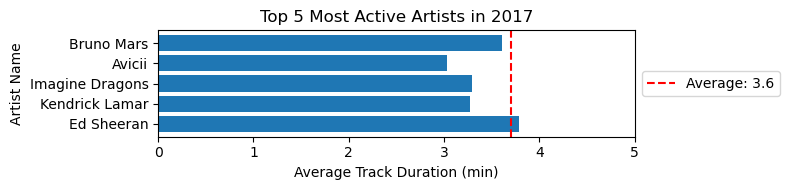

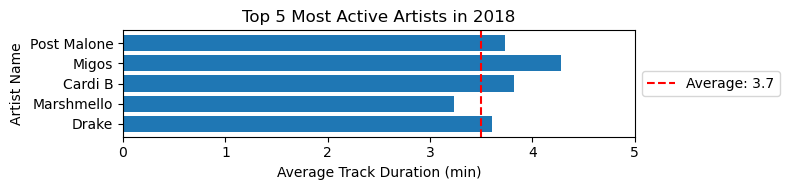

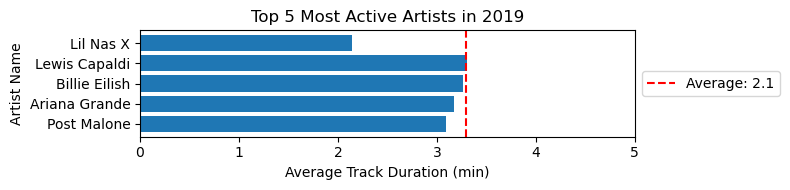

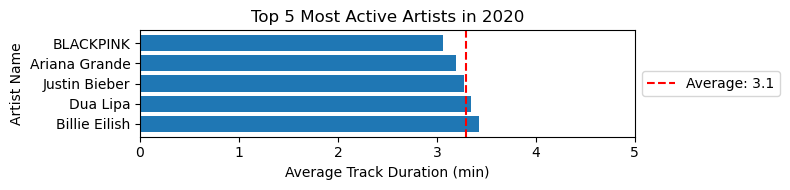

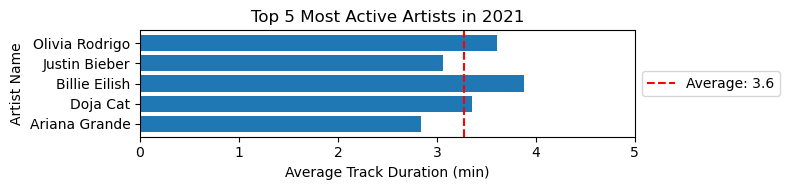

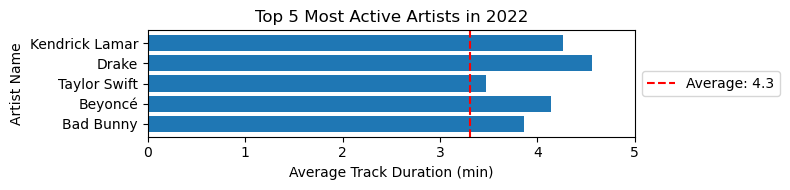

In [20]:
# Calculate the average track duration for each year
avg_duration_per_year = complete_df.groupby('Year')['duration_ms'].mean() / 60000
avg_duration_per_year = avg_duration_per_year.reset_index(name='Average Duration (min)')

# Group data by Year and artist name to calculate the average track duration for top 5 artists
grouped_by_artist = complete_df.groupby(['Year', 'artist name'])

# Get the top 5 artists for each year based on song count
for year, group in five_successful_artists_by_year.groupby('Year'):
    artist_names = []
    average_durations = []
    for index, row in group.iterrows():
        artist_name = row['artist name']
        artist_names.append(artist_name)
        # Filter data for the specific artist in the given year
        artist_data = grouped_by_artist.get_group((year, artist_name))
        # Calculate average track duration for the artist
        average_duration = artist_data['duration_ms'].mean() / 60000
        average_durations.append(average_duration)

    # Get the average duration for the specific year
    avg_duration_for_year = avg_duration_per_year[avg_duration_per_year
                                                  ['Year'] == year]['Average Duration (min)'
                                                                   ].values[0]

    # Create a bar graph for the year with a vertical line for the average duration
    plt.figure(figsize=(8, 2))
    plt.barh(artist_names, average_durations)
    plt.axvline(x=avg_duration_for_year, color='red', linestyle='--',
                label=f'Average: {average_duration:.1f}')
    plt.xlabel('Average Track Duration (min)')
    plt.ylabel('Artist Name')
    plt.title(f'Top 5 Most Active Artists in {year}')
    plt.xlim(0, 5)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.savefig(f"../output_data/top_active_artists_track_duration_{year}.png", bbox_inches='tight')
    plt.show()

## Finally I looked at if these artists appeared in every year in our sample data to determine which ones followed the hypothesis we presented of shorter songs being more popular during Covid-19.

## To begin with, I identified any artist with at least one song in each year.

In [21]:
# Group data by artist name and count the unique years each artist appears in
artists_years_count = complete_df.groupby('artist name')['Year'].nunique()

# Filter artists that appear in every year by the number of unique years matches the total number of years
consistant_artists = artists_years_count[artists_years_count == len(Years)]
# Display artists that appear in every year
print("Artists with at least one song in every year:")
print(consistant_artists.index.tolist())

Artists with at least one song in every year:
['Billie Eilish', 'Drake', 'Post Malone', 'Shawn Mendes', 'Taylor Swift']


## Then I removed Shawn Mendes as he was not one of the most active artists in any of the years in the sample size and therefore would provide little relevant data.

## For the final part of Visualisation, a linegraph would provide the clearest picture.

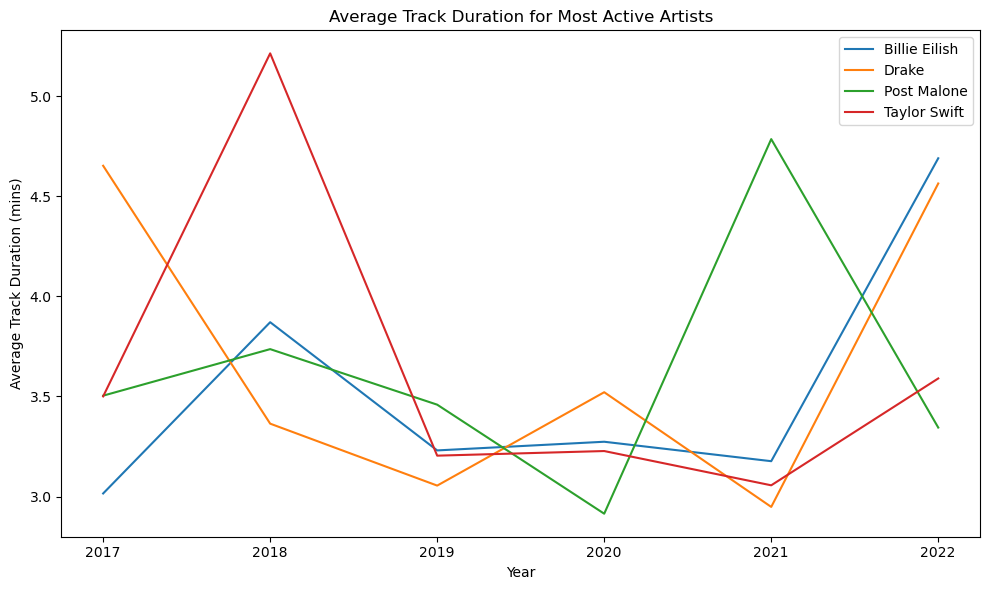

In [23]:
# Filter data for the selected artists
selected_artists = ['Billie Eilish', 'Drake', 'Post Malone', 'Taylor Swift']
selected_artists_data = complete_df[complete_df['artist name'].isin(selected_artists)]

# Group data by artist name and Year, and calculate the mean track duration for each artist for each year
grouped_artists = selected_artists_data.groupby(['artist name', 'Year'])['track_duration_mins'].mean()

# Plot a line graph for each artist's track duration over the years
plt.figure(figsize=(10, 6))
for artist in selected_artists:
    artist_data = grouped_artists.loc[artist]
    plt.plot(artist_data.index.get_level_values('Year'), artist_data.values, label=artist)

plt.xlabel('Year')
plt.ylabel('Average Track Duration (mins)')
plt.title('Average Track Duration for Most Active Artists')
plt.legend()
plt.tight_layout()
plt.savefig("../output_data/top_active_artists_trend.png", bbox_inches='tight')
plt.show()

## From the above graph we can see that most of these artists did decide to reduce they're mean song length around the covid-19 years of 2019 and 2020 which may have contributed to them remaining consistantly in the top 100 between 2017 - 2022 and having multiple hits each year in this period.